# M.2. Yields

### DRW / UChicago Prep Course

#### Chicago, Summer 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Data Source

CRSP Treasury Monthly Release
accessed via WRDS

For any given date, obtain quotes for nearly every issued Treasury.

In particular, 
* Bills, Notes, Bonds
* TIPS

In the analysis below, we exclude TIPS to focus on nominal rates.

The data set does not include Floating Rate Notes (FRNs).

In [2]:
QUOTE_DATE = '2024-04-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
data = pd.read_excel(filepath_rawdata,sheet_name='quotes').set_index('KYTREASNO')

# Yield to Maturity (YTM) and Returns

The formula for YTM looks like the pricing formula for a bond, but replacing the maturity-dependent discount rate with a constant discount rate:

### Definition

Let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:

$\begin{align}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align}
$

Note that the same rate, $y_j$, is discounting cashflows at different maturities.
* It is unique to the security, $j$.
* It is constant across the security's various cashflow maturities.

### YTM has a <span style='color:blue'>nonlinear</span> and <span style='color:blue'>inverse</span> relationship with price


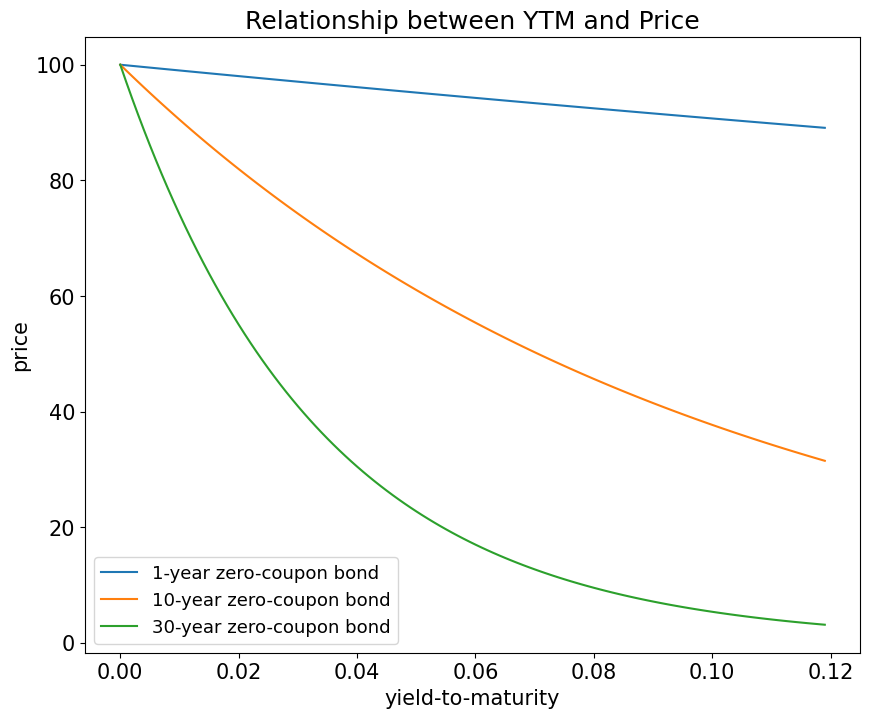

In [3]:
ylds_grid = np.arange(0,.12,.001)
T_grid = [1,10,30]
price_grid = pd.DataFrame(data=np.zeros([len(ylds_grid),len(T_grid)]), index=ylds_grid, columns=T_grid)
for T in T_grid:
    for i,y in enumerate(ylds_grid):
        price_grid.loc[y,T] = 100/(1+y/2)**(2*T)

price_grid.plot(figsize=(10,8))

legend_labels = [''] * len(T_grid)
for i,T in enumerate(T_grid):
    legend_labels[i] = f'{T}-year zero-coupon bond'

plt.xlabel('yield-to-maturity')
plt.ylabel('price')
plt.legend(legend_labels)
plt.title('Relationship between YTM and Price')
plt.show()

### YTM will differ across coupon rates, even for the same maturity

In [4]:
# find maturity where YTM differs by large amount
temp = data.pivot_table(index='maturity date',values='ytm',aggfunc={'ytm':np.ptp}).sort_values('ytm',ascending=False)
# restrict answer to maturity greater than one year, to avoid short-term liquidity explanations
idx = temp[temp.index >'2024-01-01'].index[0]

tab = data[data['maturity date']==idx]

tab[['type','quote date','issue date','maturity date','ttm','cpn rate','price','ytm','public size']].style.format(
    {'ytm':'{:.3%}',
    'issue date': '{:%Y-%m-%d}', 
    'quote date': '{:%Y-%m-%d}', 
    'maturity date': '{:%Y-%m-%d}',                                                                                                                             
    'price':'{:.2f}', 
    'cpn rate':'{:.2f}', 
    'ttm':'{:.2f}', 
    'ask-bid':'{:.2f}',
    'public size':'{:.1e}'
    })

,type,quote date,issue date,maturity date,ttm,cpn rate,price,ytm,public size
KYTREASNO,,,,,,,,,
206825,note,2024-04-30,2015-02-15,2025-02-15,0.80,2.00,97.41,5.358%,5.3e+10
204084,bond,2024-04-30,1995-02-15,2025-02-15,0.80,7.62,102.09,4.883%,3.3e+09
207844,note,2024-04-30,2022-02-15,2025-02-15,0.80,1.50,97.03,5.347%,5.0e+10


## Returns

The return on a bond between $t$ and $T$ is, like any security, the (time $T$) payoff divided by the (time $t$) price.

$
\begin{align}
\left(\frac{\text{payoff}_T}{\text{investment}_t}\right)^{\frac{1}{T-t}} - 1
\end{align}
$

Note that the exponent $1/(T-t)$ is to annualize the return.

### Conditions where return equals YTM
**The return to a bond is typically NOT the same as its YTM**

They are only equivalent if...
1. We are discussing a zero-coupon bond. (ie It only pays cashflow at maturity.)
2. The investor holds it until maturity.

## YTM vs Return for a Coupon Bond

For a coupon bond, YTM is not the same as return, whether or not the bond is held to maturity.

### YTM is the exact same as Internal Rate of Return in Corporate Finance

* YTM is a discount rate that varies by instrument but is constant across the instrument's cashflow.

* It is NOT the return, as there is no guarantee you can reinvest intermediate cashflows at the YTM.

* YTM only exists and is uniquely defined for cashflows that have the typical pattern.

### YTM is just an alternate way to quote a price

* Prices for coupon bonds have a wide range due to coupons and maturity.
* YTM is a narrower range which (partially) adjusts for the time-value of money

# The Yield Curve

The **yield curve** plots the yields against time-to-maturity.

Examine this with the ytm of every outstanding treasury issue.

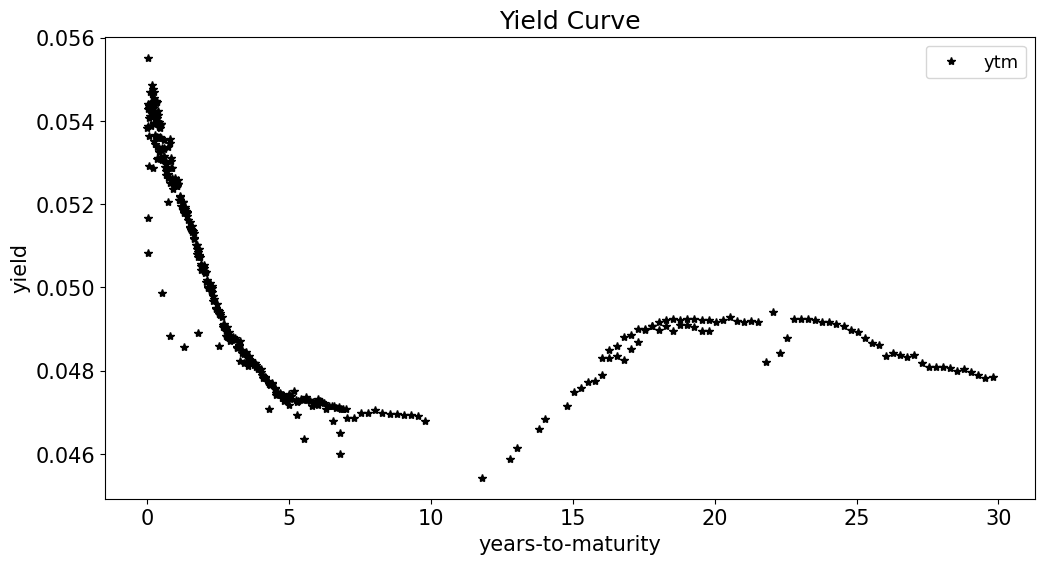

In [5]:
data.set_index('ttm')['ytm'].plot(linestyle='',marker='*', color='k')
plt.legend()
plt.xlabel('years-to-maturity')
plt.ylabel('yield')
plt.title('Yield Curve')
plt.show()

It's not exactly a curve!

### Models of the Yield Curve

The Treasury publishes **constant maturity** benchmarks:

https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202406

The Fed discusses curve-fitting of the yields here:

https://www.federalreserve.gov/data/yield-curve-models.htm

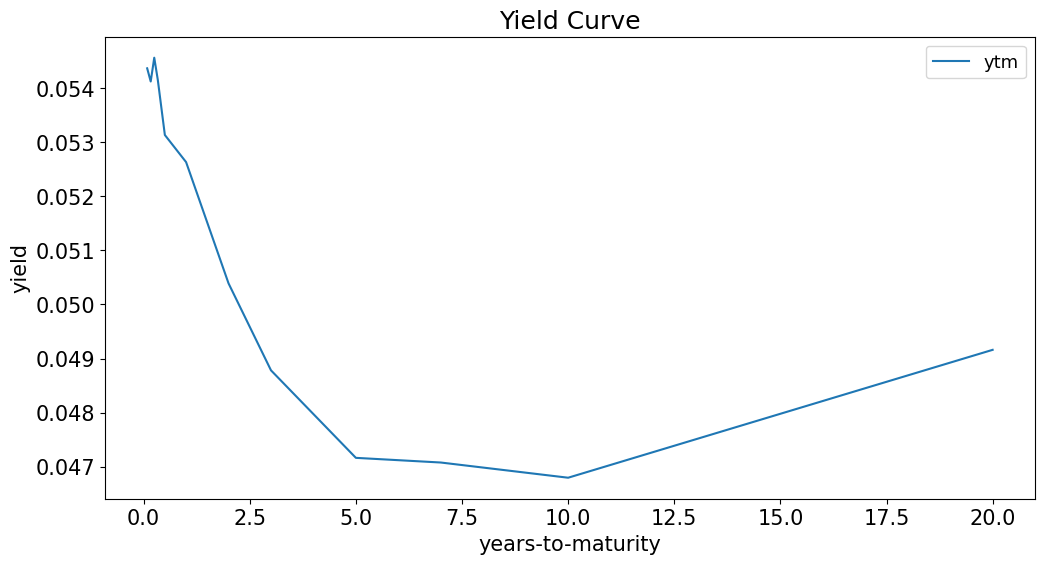

In [6]:
mats = [1/12,2/12,3/12,4/12,6/12,1,2,3,5,7,10,20,30]

ycurve_key = pd.DataFrame(dtype=float,index=mats,columns=['ytm'])
for mat in mats:
    idx = (data['ttm']-mat).abs().idxmin()
    ycurve_key.loc[mat,'ytm'] = data.loc[idx,'ytm']

ycurve_key.plot()

plt.legend()
plt.xlabel('years-to-maturity')
plt.ylabel('yield')
plt.title('Yield Curve')
plt.show()

***

# Appendix: Compounding

## Compounding
Note that the spot rate above, $r(t,T_i)$ was applied semiannually. This was chosen for convenience with the semiannual coupons. 

We could compound these spot rates to any frequency, including a continuously compounded rate.

#### When emphasizing the compounding chosen for the spot rate, we will subscript it by $n$.

| n | compounding frequency |
|-|-|
| 1 | annual |
| 2 | semiannual |
| 4 | quarterly |
| 12 | monthly |
| 52 | weekly |
| 365 | daily |
| $\infty$ | continuous |

For instance, changing the compounding from semiannually to daily would be,

$
\begin{align}
r_{365} = 365\left[\left(1+\frac{r_2}{2}\right)^{\frac{2}{365}}-1\right]
\end{align}
$

### Continuous compounding is often most useful

Because the continuously compounded rate is so useful and used so often rather than use $r_n$ we will drop the subscript entirely and just use $r$ with no subscript instead. 

The continuously compounded rate $r$ can be written as a function of the $n$-times compounded rate as follows.

$
\begin{align}
\displaystyle r &= n\ln\left(1+\frac{r_n}{n}\right)\\
\displaystyle r_n&= n\left(e^{\frac{r}{n}}-1\right)
\end{align}
$

### Discount is equivalent for any compounded rate
Note that all the compounded rates will imply the same discount, when the compounding frequency is accounted for.

$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$


### Example
Consider, as an example, the annually compounded spot rate of 5\% at a maturity of $T-t=1$.

In [7]:
rate = .05
compound_base = 1

ngrid = [1, 2, 4, 12, 52, 365]
compounded_rate = pd.DataFrame(index=ngrid,columns=['rate','discount'],dtype=float)
for n in ngrid:
    compounded_rate.loc[n] = compound_rate(rate,compound_base,n)
    compounded_rate.loc[n,'discount'] = 1/(1+compounded_rate.loc[n,'rate']/n)**n
    
compounded_rate.loc['continuous','rate'] = compound_rate(rate,compound_base,None)
compounded_rate.loc['continuous','discount'] = intrate_to_discount(compounded_rate.loc['continuous','rate'],compound_base,n_compound=None)

display(compounded_rate.style.format("{:.4%}"))

,rate,discount
1,5.0000%,95.2381%
2,4.9390%,95.2381%
4,4.9089%,95.2381%
12,4.8889%,95.2381%
52,4.8813%,95.2381%
365,4.8793%,95.2381%
continuous,4.8790%,95.2381%


***

## Appendix

## Imputed Calculations

CRSP provides the following widely-used bond metrics
* Yield to maturity
* Several others we discuss later in this training. (Notably, duration.)

These imputed metrics are missing for data that is suspect.
* Specifically, the data provider (CRSP) is flaggign bid-ask spreads greater than $0.08.
* Missing for a small number of other issues.
* For modeling, we will filter out any such issues.
* We can then apply the model to see how it compares to these (likely) erroneous values.

In [8]:
data['ask-bid'] = data['ask'] - data['bid']
display(data.sort_values('ask-bid').tail(5))

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,public size,ask-bid
KYTREASNO,,,,,,,,,,,,,,,
207068,TIPS note,2024-04-30,2017-02-15,2047-02-15,22.795346,0.0,0.875,72.449219,72.660156,72.554688,0.0,72.554688,NaN,1.200900e+10,0.210938
207188,TIPS note,2024-04-30,2018-02-15,2048-02-15,23.794661,0.0,1.000,73.859375,74.078125,73.968750,0.0,73.968750,NaN,8.918000e+09,0.218750
207327,TIPS note,2024-04-30,2019-02-15,2049-02-15,24.796715,0.0,1.000,73.234375,73.457031,73.345703,0.0,73.345703,NaN,8.525000e+09,0.222656
208020,TIPS note,2024-04-30,2023-02-15,2053-02-15,28.796715,0.0,1.500,80.972656,81.234375,81.103516,0.0,81.103516,NaN,1.698700e+10,0.261719
208191,TIPS note,2024-04-30,2024-02-15,2054-02-15,29.796030,0.0,2.125,93.847656,94.144531,93.996094,0.0,93.996094,NaN,8.989000e+09,0.296875


# Appendix

## YTM vs Return for a Zero Coupon Bond

### If held until maturity, (return interval is t, T)
$
\begin{align}
\hat{r}_{t,T} =& \left(\frac{100}{P_z(t,T)}\right)^{\frac{1}{T-t}} - 1 = \left(\frac{100}{100Z(t,T)}\right)^{\frac{1}{T-t}} - 1 \\
=& \frac{1}{Z(t,T)^{\frac{1}{T-t}}} - 1
\end{align}
$

which is a function only of today's discount rate, $Z(t,T)$, which means this return is known now.

### If not held until maturity, but rather over the interval (t, t+h),

$
\begin{align}
\hat{r}_{t,t+h} =& \left(\frac{P_z(t+h,T)}{P_z(t,t+h)}\right)^{\frac{1}{h}} - 1 \\
=& \left(\frac{Z(t+h,T)}{Z(t,t+h)}\right)^{\frac{1}{h}} - 1 
\end{align}
$

which is a function of the discount rate at $t+h$. 

**Thus, this return is unknown at $t$. It is subject to interest-rate risk impacting $Z(t+h,T)$.**

### Log Returns

The cumulative log return between $t$ and $T$ is defined as

$
\begin{align}
\hat{\texttt{r}}_{t,T} = \frac{1}{T-t}\ln(1+ \hat{r}_{t,T})
\end{align}
$

Note that it is standard to normalize this return to the time interval under consideration, $T-t$:

For a zero-coupon bond this is,

$
\begin{align}
\hat{\texttt{r}}_{t,T} = \frac{1}{T-t}\ln(\frac{1}{Z(t,T)}) = -\frac{1}{T-t}\ln\left(Z(t,T)\right)
\end{align}
$

Thus, the annualized log return of holding the zero-coupon bond to maturity is exactly equivalent to the continuously-compounded spot rate.

**So for log returns and log yields we find the same: return equals YTM for zero-coupon bonds held to maturity.**